# Timing tests from XMM run

Some times were estimated from the SXDS field which hass many more exposures so will not be representative of the VHS all SKy data. Here we will reestimate full sky timing estimates from the XMM run to see how processes such as coaddition scale with exposure number.

In [21]:
import astropy.units as u
from astropy.table import Table
from astropy.time import Time
import numpy as np
import glob
import json

import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
#and copied for obs_vista
#https://github.com/lsst-uk/obs_vista/blob/master/config/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 # Overlap between tracts (degrees)
config.pixelScale = 0.168
sm = RingsSkyMap(config)
sxds_tracts = [8282,8283,8284,8523,8524,8525,8765,8766,8767] #manually got these from HSC DR2 pages

In [7]:
SUFFIX=time.strftime("%Y%m%d")
WORK_DIR = '/home/ir-shir1/rds/rds-iris-ip005/ras81/lsst-ir-fusion/dmu4/dmu4_SXDS'
MAKE_INDIVIDUAL_SLURM=True
SLURM_DIR = 'slurm_failed_tiles_rerun_{}'.format(SUFFIX)
print(SUFFIX)

20201204


In [9]:
!ls ./slurm

0_setup_butler.sh                    completeForced_VISTA-Ks_20201204.lis
1_Ingest.slurm                       credentials.py.template
2_processCcd.slurm                   jobDict.py
3_coadd.slurm                        patch_job_dict.json
4_photopipe.slurm                    photopipe.sh
all_jobs_20201204.lis                processCcd.sh
coadd.sh                             processCcd_job_dict.json


In [11]:
#USE HSC-Y which is the last task run in the pipeline
#forced = glob.glob('./data/rerun/coaddForcedPhot/deepCoadd-results/HSC-Y/*/*/*.fits)
f = open('./slurm/completeForced_VISTA-Ks_20201204.lis', "r")
forced = [l for l in f]

In [12]:
forced[-1]

'data/rerun/coaddForcedPhot/deepCoadd-results/VISTA-Ks/9496/8,6/forcedSrc-VISTA-Ks-9496-8,6.fits\n'

In [13]:
len(forced)

3440

In [37]:
forced[-1].split('/')[5]

'9496'

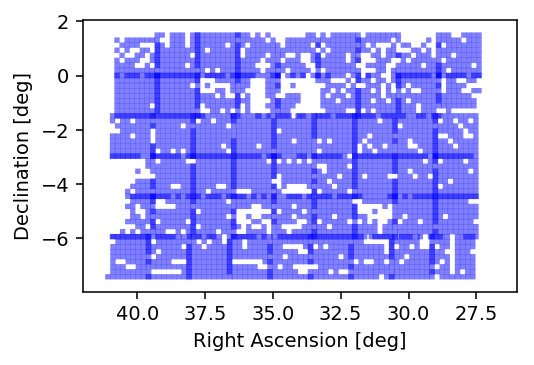

In [41]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for f in forced:
    t = sm.generateTract(int(f.split('/')[5]))
    p = [int(f.split('/')[6][0]), int(f.split('/')[6][2])]
    vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
    ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
    dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
    ax.fill(ra, dec, c = 'b', alpha=0.5, linewidth=0.1)


        

#v_band ='Ks'
#for t in vhs_ims[(vhs_ims['type'] == 'tile') & (vhs_ims['filter'] == v_band) ]:
#    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
#    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ] 
#    ax.fill(ra,dec, c = 'b', alpha=0.3)
        
        
        

ax.axis('scaled')
ax.set_xlim([42, 26])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/xmm_VHS_passed_Ks_patches.pdf', overwrite=True)
fig.savefig('./figs/xmm_VHS_passed_Ks_patches.png', overwrite=True)

## Times

In [16]:

t = Table.read('slurm/all_jobs_20201204.lis', format='ascii')

In [17]:
"I have submitted a total of {} jobs consuming a total of {} cpuhours".format(len(t), np.sum(t['CompHrs']))

'I have submitted a total of 49060 jobs consuming a total of 102290.69999999998 cpuhours'

In [18]:
t[:5]


JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs
str12,str8,str10,str10,str10,str19,str5,str10,float64
25933230,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-13T16:18:36,127:0,FAILED,0.1
25940256,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T00:08:41,1:0,FAILED,74.2
25948528,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-14T14:34:59,0:0,COMPLETED,254.3
26005193,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-16T03:59:49,0:0,TIMEOUT,640.0
26027949,ir-shir1,iris-ip00+,cpujob,skylake,2020-07-17T10:46:53,0:0,TIMEOUT,1536.4


In [ ]:
for n in 

In [19]:
t[-5:]


JobID,User,Account,JobName,Partition,End,ExitCode,State,CompHrs
str12,str8,str10,str10,str10,str19,str5,str10,float64
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:30:41,1:0,FAILED,0.5
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:29:01,1:0,FAILED,0.5
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:39:24,1:0,FAILED,0.7
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T20:15:16,1:0,FAILED,1.3
32018844_43+,ir-shir1,iris-ip00+,photopipe,skylake,2020-12-03T19:25:15,2:0,FAILED,0.5


In [22]:
times = Time(t['End'], format='isot', scale='utc')

In [24]:
t['mjd_end'] = times.mjd

In [26]:
t = t[t['mjd_end'] > 59176]

In [27]:

def nameToJobType(name):
    """Take the name and return the tipe of pipetask"""
    job_type = 'UNKNOWN'
    if name.startswith('process'):
        job_type = 'processCcd'
    if name.startswith('coadd'):
        job_type = 'coadd'
    if name.startswith('phot'):
        job_type = 'photoPipe'
    return job_type

t['job_type']  = [nameToJobType(n) for n in t['JobName']]

In [33]:
t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [34]:
num_processCcd = len(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
num_coadd= len(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
num_photo = len(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

tot_processCcd = np.sum(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
tot_coadd= np.sum(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
tot_photo = np.sum(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patch coadss and {} patch photometry pipelines: {} cpu hours
""".format(
    round(mean_processCcd,2),
    round(mean_coadd,2),
    round(mean_photo,2),
    num_processCcd,
    num_coadd,
    num_photo,
    round(
        tot_processCcd 
        + tot_coadd
        + tot_photo,2
    )
))


Full processing of input images: 1.87 cpu hours
Full coadd of all patches: 0.13 cpu hours
Full photometry pipeline on all patches: 2.05 cpu hours
Total time for 5467 images and 7664 patch coadss and 13 patch photometry pipelines: 11243.1 cpu hours



In [35]:
n_vhs_xmm_images = 2226 # From ../dmu4_XMM/1_Slurm_factory.ipynb
n_vhs_xmm_patches = 6*9*81 #Rough from tract numbers

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patches: {} cpu hours
""".format(
    round(n_vhs_xmm_images * mean_processCcd),
    round(n_vhs_xmm_patches* mean_coadd),
    round(n_vhs_xmm_patches* mean_photo),
    n_vhs_xmm_images, n_vhs_xmm_patches,
    round(
        n_vhs_xmm_images * mean_processCcd 
        + n_vhs_xmm_patches* mean_coadd
        + n_vhs_xmm_patches* mean_photo
    )
))


Full processing of input images: 4160.0 cpu hours
Full coadd of all patches: 571.0 cpu hours
Full photometry pipeline on all patches: 8984.0 cpu hours
Total time for 2226 images and 4374 patches: 13714.0 cpu hours



In [36]:
n_vhs_xmm_images = 204996 # From ../dmu1/data/vhs_images_overview_$DATE.fits
n_vhs_xmm_patches =  670137# From ../dmu1/data/vhs_tiles_tracts_patches.fits

mean_processCcd = np.mean(t['CompHrs'][(t['job_type'] == 'processCcd') &(t['State'] == 'COMPLETED') ])
mean_coadd= np.mean(t['CompHrs'][(t['job_type'] == 'coadd') &(t['State'] == 'COMPLETED') ])
mean_photo = np.mean(t['CompHrs'][(t['job_type'] == 'photoPipe') &(t['State'] == 'COMPLETED') ])

print("""
Full processing of input images: {} cpu hours
Full coadd of all patches: {} cpu hours
Full photometry pipeline on all patches: {} cpu hours
Total time for {} images and {} patches: {} cpu hours
""".format(
    round(n_vhs_xmm_images * mean_processCcd),
    round(n_vhs_xmm_patches* mean_coadd /6), #assume 6 times fewer images to coadd
    round(n_vhs_xmm_patches* mean_photo ),  #assume JHK and LSST UGRIZY
    n_vhs_xmm_images, n_vhs_xmm_patches,
    round(
        n_vhs_xmm_images * mean_processCcd 
        + n_vhs_xmm_patches* mean_coadd/6
        + n_vhs_xmm_patches* mean_photo
    )
))


Full processing of input images: 383084.0 cpu hours
Full coadd of all patches: 14573.0 cpu hours
Full photometry pipeline on all patches: 1376358.0 cpu hours
Total time for 204996 images and 670137 patches: 1774016.0 cpu hours



In [ ]:
from lsst.obs.vista import vistaFilters